In [1]:
import time

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# from fast_slic import Slic
from fast_slic.avx2 import SlicAvx2 as Slic
from skimage.util import img_as_float
from torch_scatter import scatter, segment_coo, segment_csr

Fast SLIC took 0.050479888916015625


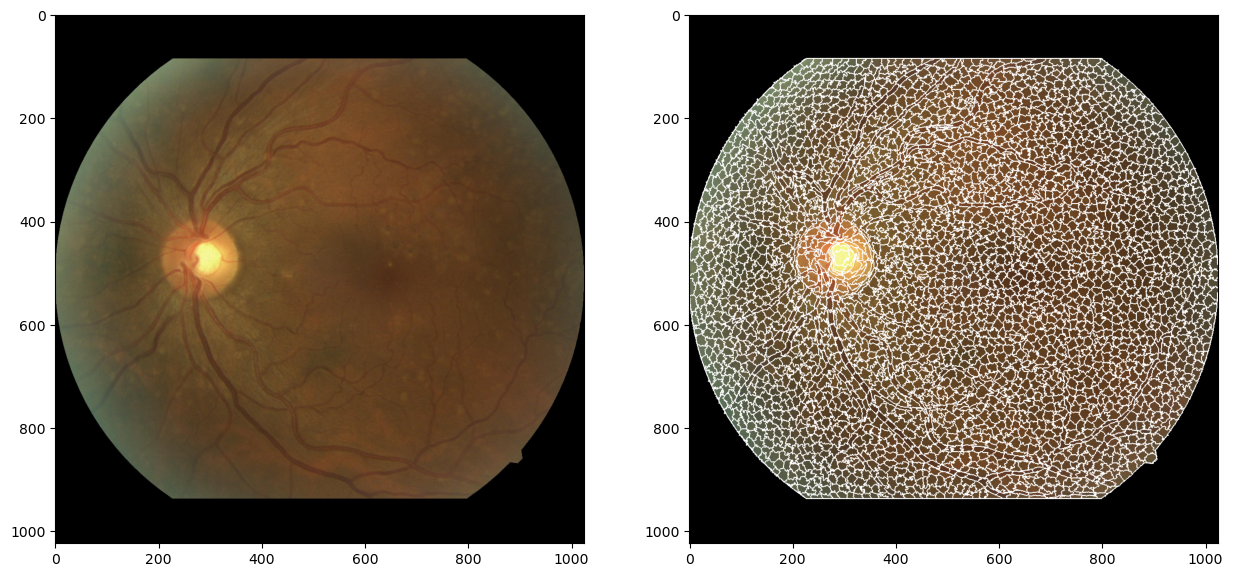

In [2]:
img = cv2.imread('../../../data/eyepacs/train/images/9984_left.png')[:, :, ::-1]
shape = (1024, 1024)
img = cv2.resize(img, shape)
n_segments_large = 128
n_segments_small = 4096
n_segments_fast = n_segments_small
start = time.time()
fastSlic = Slic(num_components=n_segments_fast, compactness=10, convert_to_lab=False,
                min_size_factor=0,
                manhattan_spatial_dist=True)
assignment = fastSlic.iterate(img)

print(f'Fast SLIC took {time.time()-start}')


segmentsFast = assignment
segmentsFast[img[:,:,0] < 10] = 0

kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))

gradientFast = cv2.morphologyEx(segmentsFast.astype(np.uint8), cv2.MORPH_GRADIENT, kernel)


combinedFast = img.copy()


combinedFast[gradientFast>0] = [255, 255, 255]

fig, axs = plt.subplots(1, 2)
axs[0].imshow(img)
axs[1].imshow(combinedFast)

fig.set_size_inches(15, 15)
fig.show()


import kornia as K
import torch.nn.functional as F

segment = torch.from_numpy(segmentsFast).long().unsqueeze(0)

bar = F.one_hot(segment, num_classes=n_segments_fast).permute(0, 3, 1, 2).float()
Nrow, Ncol = bar.shape[2:]
center_row = torch.round(bar.sum(dim=2).argmax(-1))
center_col = torch.round(bar.sum(dim=3).argmax(-1))
indices = center_col*Nrow + center_row
plt.imshow(bar.squeeze(0)[64])
segment_square = torch.zeros_like(bar).flatten(2)
ones = torch.ones_like(segment_square)
segment_square.scatter_add_(2, indices.unsqueeze(2), ones)
segment_square = segment_square.view(bar.shape)

dilated_square = K.morphology.dilation(segment_square.argmax(1, keepdim=True), kernel=torch.ones(3, 3))

plt.imshow(dilated_square.squeeze())
plt.show()


partitions = np.linspace(0, n_segments_fast, 8).astype(int)

conv_kernel = torch.randn(512, 3, 16, 16)
for cur_par, next_par in zip(partitions[0:-1], partitions[1:]):
    cur_seg = segment_square[:, cur_par:next_par].sum(1, keepdim=True)
    cur_seg = cur_seg.expand(-1, 3, -1, -1)
    cur_seg = F.conv2d(cur_seg, conv_kernel, padding='same')
    # plt.imshow(cur_seg.squeeze()[0]>0)
    # plt.show()
    # print(cur_seg.shape)

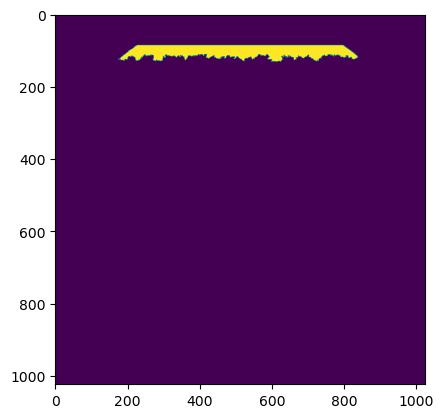

torch.Size([1, 3, 45, 663])


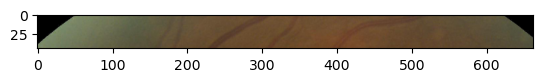

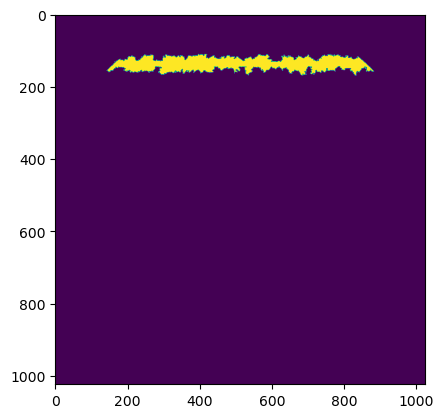

torch.Size([1, 3, 59, 739])


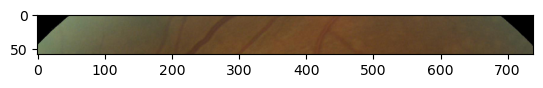

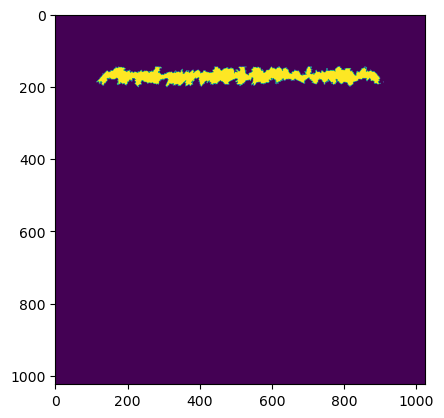

torch.Size([1, 3, 56, 794])


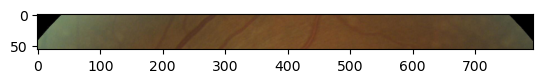

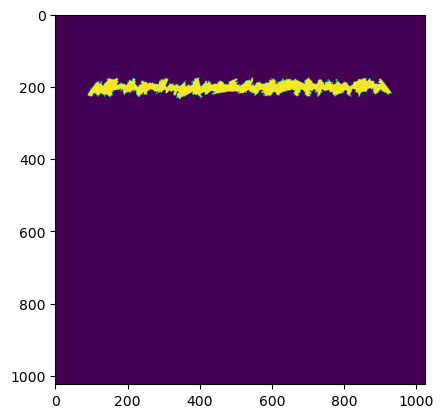

torch.Size([1, 3, 59, 843])


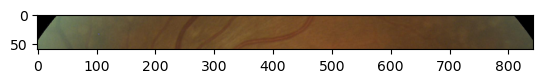

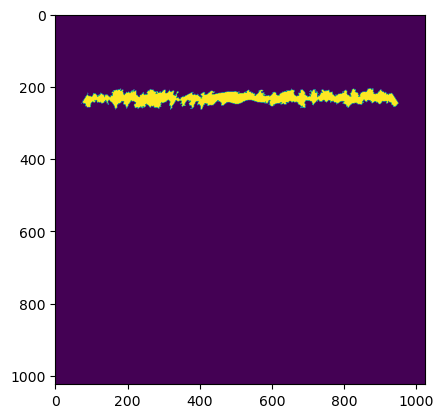

torch.Size([1, 3, 58, 878])


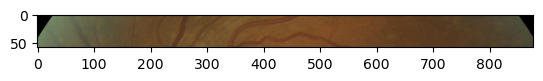

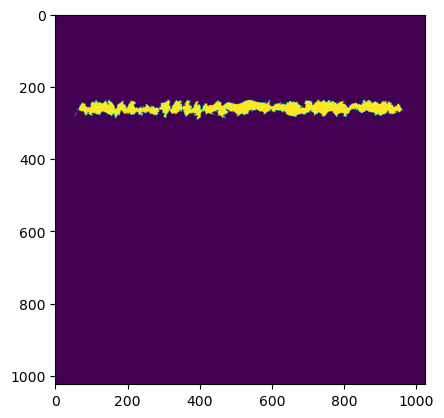

torch.Size([1, 3, 54, 909])


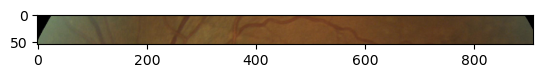

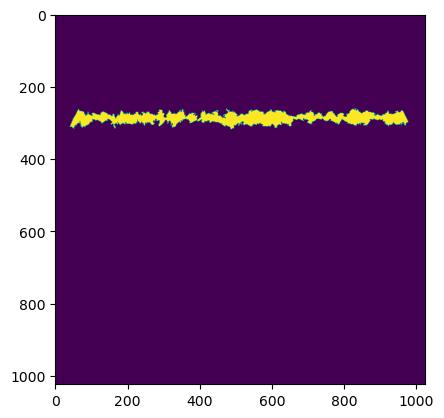

torch.Size([1, 3, 57, 936])


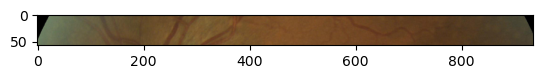

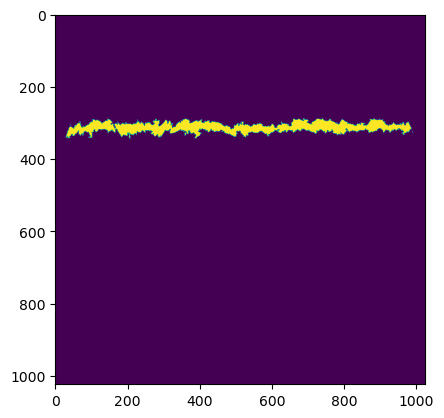

torch.Size([1, 3, 54, 960])


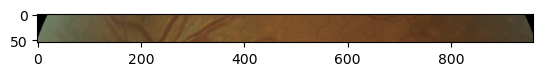

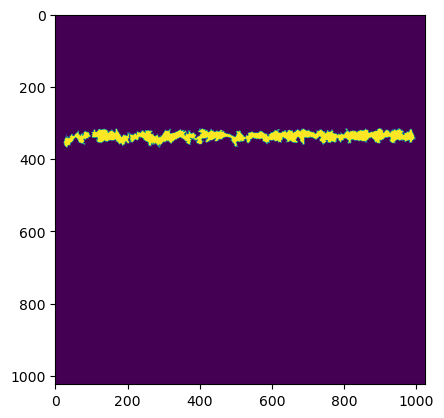

torch.Size([1, 3, 53, 973])


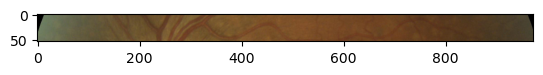

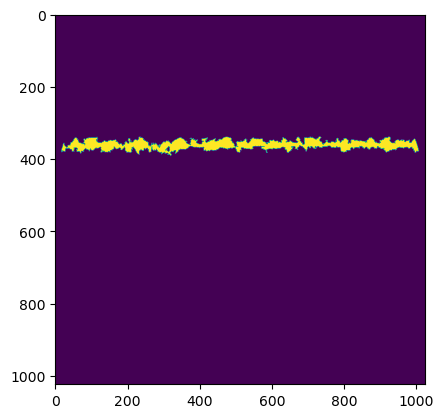

torch.Size([1, 3, 53, 989])


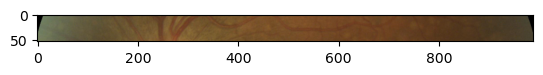

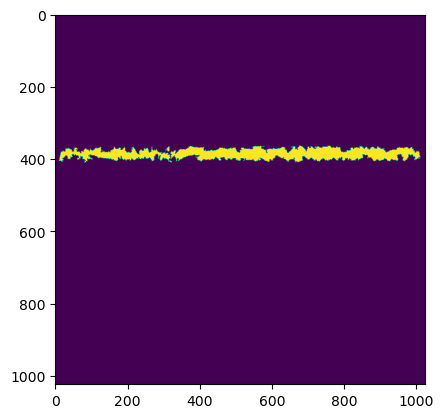

torch.Size([1, 3, 46, 999])


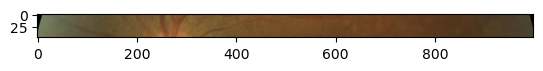

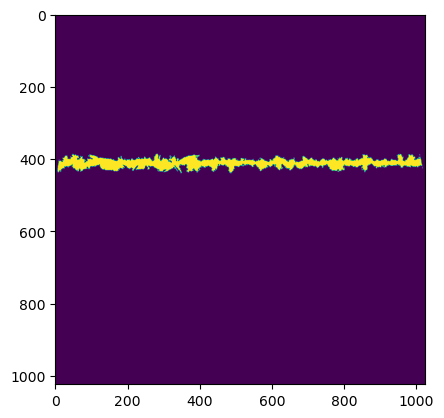

torch.Size([1, 3, 53, 1011])


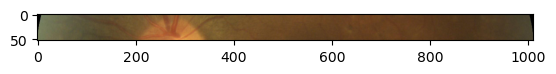

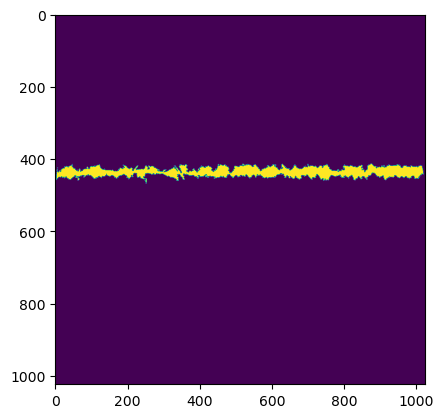

torch.Size([1, 3, 54, 1016])


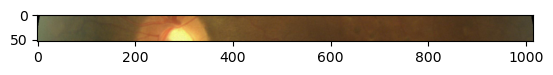

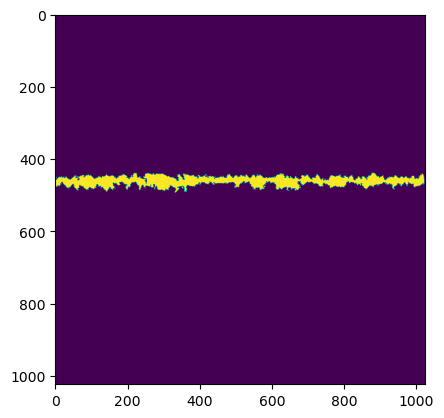

torch.Size([1, 3, 54, 1021])


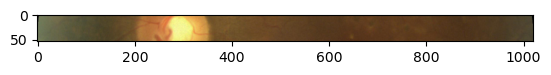

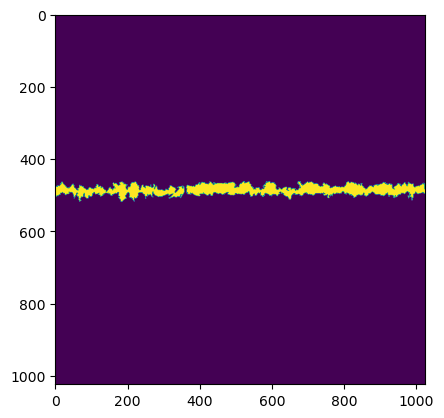

torch.Size([1, 3, 56, 1023])


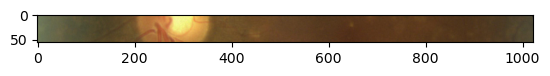

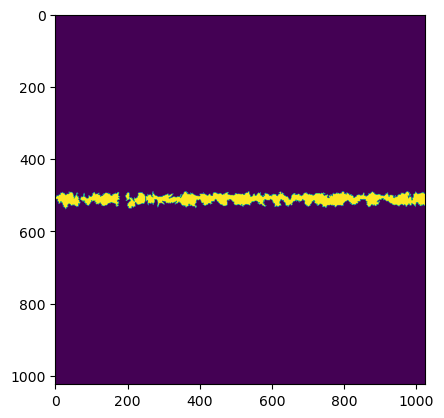

torch.Size([1, 3, 48, 1023])


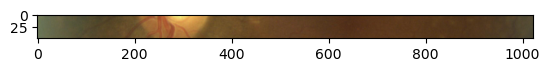

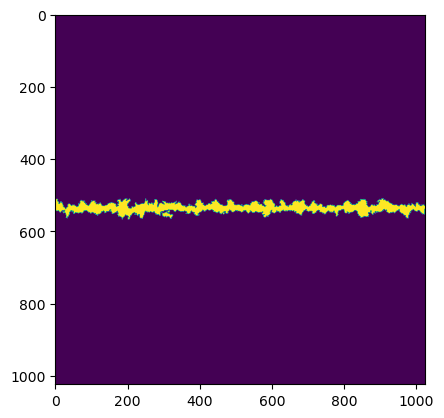

torch.Size([1, 3, 58, 1023])


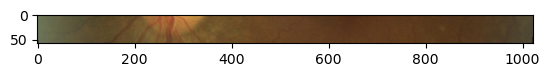

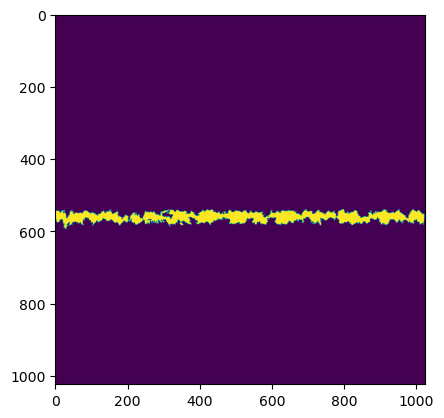

torch.Size([1, 3, 54, 1021])


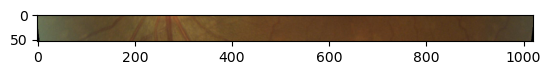

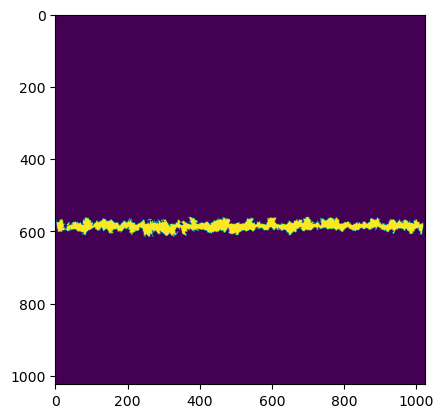

torch.Size([1, 3, 54, 1016])


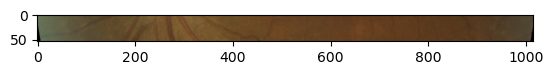

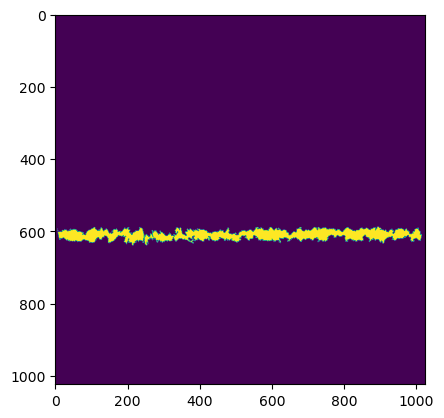

torch.Size([1, 3, 50, 1008])


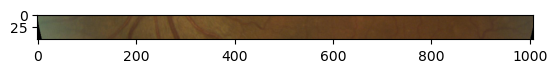

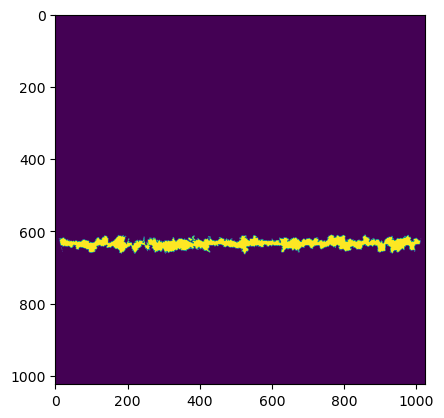

torch.Size([1, 3, 53, 1001])


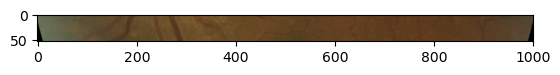

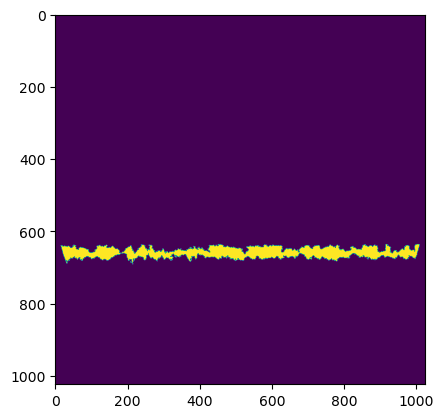

torch.Size([1, 3, 55, 992])


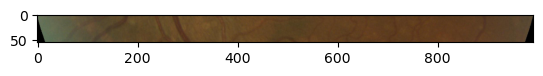

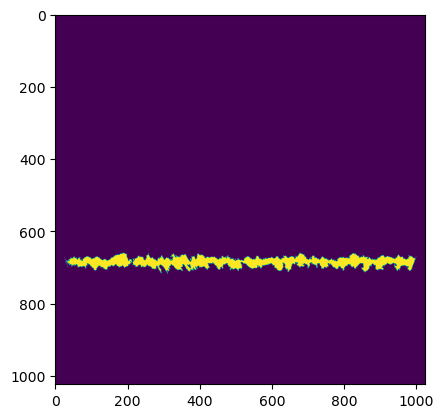

torch.Size([1, 3, 56, 973])


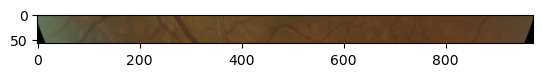

KeyboardInterrupt: 

In [35]:
x = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).float()
segments = torch.from_numpy(segmentsFast).long().unsqueeze(0)

_, segments = torch.unique(segments, return_inverse=True) 
partitions = np.linspace(1, segments.max(), 64).astype(int)

for cur_par, next_par in zip(partitions[0:-1], partitions[1:]):
    region = (segments >= cur_par) & (segments < next_par)
    plt.imshow(region.squeeze())
    plt.show()
    batch_region = region.sum(0)>0
    non_zeros = torch.nonzero(batch_region)
    
    y_range = (torch.min(non_zeros[:, 0]), torch.max(non_zeros[:, 0]))
    x_range = (torch.min(non_zeros[:, 1]), torch.max(non_zeros[:, 1]))
    x_local = x[:, :, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    print(x_local.shape)
    plt.imshow(x_local.squeeze().permute(1, 2, 0).numpy().astype(np.uint8))
    plt.show()


